In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import *
import xgboost as xgb
from pycaret.classification import *


In [2]:
df = pd.read_json('transactionsjson.json',lines=True)

In [3]:
#feature engineering

#Change columns to datetime
df.transactionDateTime = pd.to_datetime(df.transactionDateTime.str.strip())
df.dateOfLastAddressChange = pd.to_datetime(df.dateOfLastAddressChange.str.strip())
df.accountOpenDate = pd.to_datetime(df.accountOpenDate.str.strip())


#Time features
df['month'] = df.transactionDateTime.dt.month
df['day'] = df.transactionDateTime.dt.day
df['hour'] = df.transactionDateTime.dt.hour

#Create a few features that combine matching columns into True/False 

df['CVVMatch'] = (df.cardCVV == df.enteredCVV)
df['accountDiff'] = (df.accountOpenDate - df.dateOfLastAddressChange).dt.days
df['acqCountry_merchant_match'] = (df.merchantCountryCode == df.acqCountry)


#Numeric Ratios
df['creditRatio'] = df['creditLimit'] / df['availableMoney']
df['transactionRatio'] = df['transactionAmount'] / df['availableMoney']
df['balanceRatio'] = df['currentBalance'] / df['availableMoney']
df['balanceCreditRatio'] = df['currentBalance'] / df['creditLimit']


In [4]:
#Select Relevant Columns
#Drop duplicate,empty,irrelevant columns
df = df.drop([
    'merchantCountryCode',
    'acqCountry',
    'cardCVV',
    'enteredCVV',
    'cardLast4Digits',
    'customerId',
    'accountNumber',
    'echoBuffer',
    'merchantCity',
    'merchantState',
    'merchantZip',
    'posOnPremises',
    'recurringAuthInd',
],
             axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   creditLimit                786363 non-null  int64         
 1   availableMoney             786363 non-null  float64       
 2   transactionDateTime        786363 non-null  datetime64[ns]
 3   transactionAmount          786363 non-null  float64       
 4   merchantName               786363 non-null  object        
 5   posEntryMode               786363 non-null  object        
 6   posConditionCode           786363 non-null  object        
 7   merchantCategoryCode       786363 non-null  object        
 8   currentExpDate             786363 non-null  object        
 9   accountOpenDate            786363 non-null  datetime64[ns]
 10  dateOfLastAddressChange    786363 non-null  datetime64[ns]
 11  transactionType            786363 non-null  object  

Memory useage is high and running these models was already bogging down my computer so any ways to reduce memory are welcome.

In [6]:
#change to 32 to reduce memory
df = df.astype({
    "creditLimit": 'category',
    'availableMoney': 'float32',
    'transactionAmount': 'float32',
    'merchantName': 'category',
    'posEntryMode': 'category',
    'posConditionCode': 'category',
    'merchantCategoryCode': 'category',
    'currentExpDate': 'category',
    'transactionType': 'category',
    'currentBalance': 'float32',
    'creditRatio': 'float32',
    'transactionRatio': 'float32',
    'balanceRatio': 'float32',
    'balanceCreditRatio': 'float32',
    'month': 'category',
    'day': 'category',
    'hour': 'category',
    'accountDiff': 'float32',
})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   creditLimit                786363 non-null  category      
 1   availableMoney             786363 non-null  float32       
 2   transactionDateTime        786363 non-null  datetime64[ns]
 3   transactionAmount          786363 non-null  float32       
 4   merchantName               786363 non-null  category      
 5   posEntryMode               786363 non-null  category      
 6   posConditionCode           786363 non-null  category      
 7   merchantCategoryCode       786363 non-null  category      
 8   currentExpDate             786363 non-null  category      
 9   accountOpenDate            786363 non-null  datetime64[ns]
 10  dateOfLastAddressChange    786363 non-null  datetime64[ns]
 11  transactionType            786363 non-null  category

Changing the datatypes managed to reduce memory usage from 129mb to 54mb around 1/2 size very worth it.
Notably the float64 to float32 and changing the objects to categories.

# PyCaret Environment and Data Prep

Now we will setup the environment where PyCaret has lots of useful options for data prep.  
Below is a list of options from rebalancing to encoding, imputing, and more.  Below is the output of parameters included in the setup.  

In [8]:
clf = setup(data=df,
            target='isFraud',
            use_gpu=True,
            fold=5,
            remove_multicollinearity=True,
            multicollinearity_threshold=.95,
            combine_rare_levels=True,
            ignore_low_variance=True,
            feature_ratio=True,
            n_jobs=7)

,Description,Value
0,session_id,6173
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(786363, 26)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,14
8,Ordinal Features,False
9,High Cardinality Features,False


Lets run a bunch of classifier models to see how they compare. 

In [19]:
best = compare_models(sort = 'AUC', exclude=['gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9850,0.8232,0.0577,0.7599,0.1072,0.1052,0.2066,9.3820
xgboost,Extreme Gradient Boosting,0.9851,0.8185,0.0562,0.8890,0.1056,0.1040,0.2209,23.4380
catboost,CatBoost Classifier,0.9852,0.8094,0.0559,0.9904,0.1058,0.1043,0.2332,21.4400
et,Extra Trees Classifier,0.9853,0.7759,0.0651,0.9869,0.1221,0.1204,0.2514,198.3500
rf,Random Forest Classifier,0.9847,0.7747,0.0223,1.0000,0.0436,0.0430,0.1474,106.5780
ada,Ada Boost Classifier,0.9843,0.7624,0.0001,0.1000,0.0003,0.0003,0.0037,145.0700
lda,Linear Discriminant Analysis,0.9811,0.7548,0.0380,0.1363,0.0593,0.0528,0.0642,64.4220
nb,Naive Bayes,0.6816,0.7189,0.5913,0.0356,0.0629,0.0351,0.0811,7.7880
lr,Logistic Regression,0.9843,0.7001,0.0004,0.3500,0.0009,0.0008,0.0115,69.9860
dt,Decision Tree Classifier,0.9726,0.5531,0.1200,0.1215,0.1207,0.1068,0.1069,137.7320


Lets try to blend or stack the top few models to see if we can improve roc and precision. 

In [20]:
 blends = compare_models(n_select = 4, include = ['xgboost','lightgbm','catboost','et'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9853,0.7759,0.0651,0.9869,0.1221,0.1204,0.2514,196.4480
catboost,CatBoost Classifier,0.9852,0.8095,0.0559,0.9904,0.1058,0.1043,0.2332,22.5540
xgboost,Extreme Gradient Boosting,0.9851,0.8185,0.0562,0.8890,0.1056,0.1040,0.2209,22.8540
lightgbm,Light Gradient Boosting Machine,0.9850,0.8232,0.0577,0.7599,0.1072,0.1052,0.2066,9.9240


In [21]:
#blend top 4 base models 
blender = blend_models(blends, choose_better = True, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9852,0.8351,0.0558,0.9872,0.1056,0.1041,0.2329
1,0.9850,0.8421,0.0428,0.9672,0.0819,0.0807,0.2017
2,0.9850,0.8340,0.0435,0.9677,0.0833,0.0820,0.2035
3,0.9850,0.8406,0.0486,0.9437,0.0924,0.0910,0.2122
4,0.9853,0.8555,0.0645,0.9780,0.1210,0.1193,0.2492
Mean,0.9851,0.8415,0.0510,0.9688,0.0968,0.0954,0.2199
SD,0.0001,0.0077,0.0082,0.0145,0.0148,0.0146,0.0184


In [48]:
#try to stack models 
#stacker = stack_models(blends,choose_better = True, optimize='AUC')
#did not yield better results.. 

Here are some metrics on the blended model. We see slightly improved AUC with very high precision. 

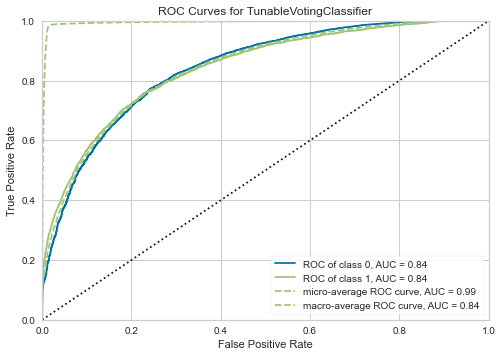

In [22]:
plot_model(blender, plot = 'auc')

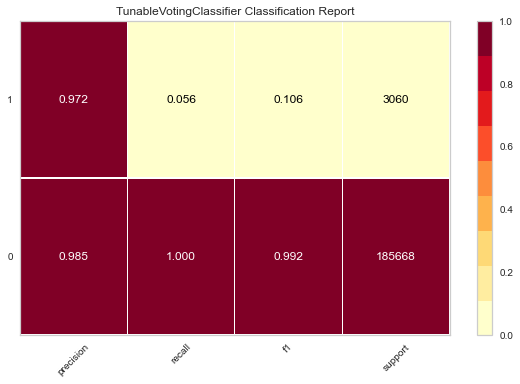

In [23]:
plot_model(blender, plot = 'class_report')

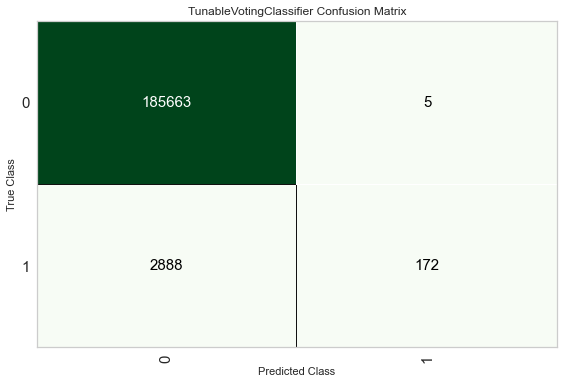

In [32]:
plot_model(blender, plot = 'confusion_matrix')

In [25]:
pred_holdout_blender = predict_model(blender)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9847,0.8429,0.0562,0.9718,0.1063,0.1047,0.2318


# Model Evaluation - Feature Analysis

This blended model yields the best AUC but we can't access the features and see their importance so it's a bit of a blackbox.  The best way to improve the model would still be to try out different feature engineering based on the feature importance returned from the models.  
Lets run all 3 top models individually and see what features they used.

In [9]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9852,0.8224,0.0658,0.8976,0.1226,0.1207,0.2408
1,0.9853,0.8208,0.0739,0.9014,0.1365,0.1345,0.2557
2,0.9852,0.8453,0.0698,0.8897,0.1295,0.1275,0.2469
3,0.9850,0.8249,0.0583,0.8707,0.1092,0.1075,0.2231
4,0.9850,0.8216,0.0571,0.8319,0.1069,0.1051,0.2157
Mean,0.9851,0.8270,0.0650,0.8783,0.1210,0.1190,0.2364
SD,0.0001,0.0093,0.0065,0.0255,0.0114,0.0113,0.0149


In [10]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9849,0.8300,0.0675,0.7178,0.1234,0.1210,0.2172
1,0.9852,0.8322,0.0750,0.8125,0.1373,0.1350,0.2442
2,0.9852,0.8394,0.0739,0.8366,0.1357,0.1335,0.2460
3,0.9850,0.8305,0.0612,0.7852,0.1135,0.1115,0.2166
4,0.9848,0.8204,0.0594,0.7103,0.1097,0.1075,0.2027
Mean,0.9850,0.8305,0.0674,0.7725,0.1239,0.1217,0.2253
SD,0.0001,0.0061,0.0064,0.0505,0.0112,0.0112,0.0170


In [28]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9852,0.8120,0.0583,1.0000,0.1101,0.1086,0.2396
1,0.9852,0.8131,0.0589,0.9808,0.1111,0.1095,0.2384
2,0.9853,0.8259,0.0669,0.9831,0.1253,0.1236,0.2546
3,0.9850,0.8125,0.0490,1.0000,0.0935,0.0922,0.2198
4,0.9850,0.8106,0.0531,0.9200,0.1004,0.0988,0.2190
Mean,0.9851,0.8148,0.0572,0.9768,0.1081,0.1065,0.2343
SD,0.0001,0.0056,0.0060,0.0295,0.0108,0.0107,0.0134


In [29]:
pred_holdout_cat = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9850,0.8242,0.0600,0.9825,0.1130,0.1114,0.2408


In [11]:
pred_holdout_xg = predict_model(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9850,0.8367,0.0658,0.8697,0.1224,0.1204,0.2369


In [12]:
pred_holdout_lg = predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9847,0.8355,0.0648,0.7105,0.1187,0.1164,0.2116


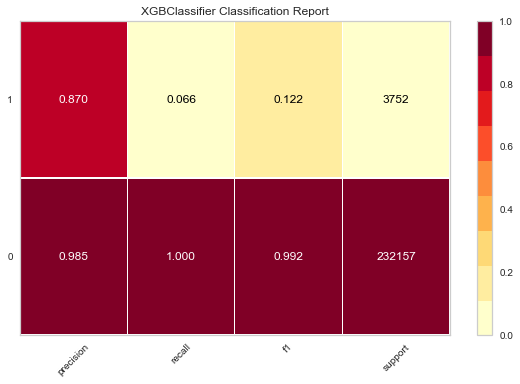

In [13]:
plot_model(xgboost, plot = 'class_report')

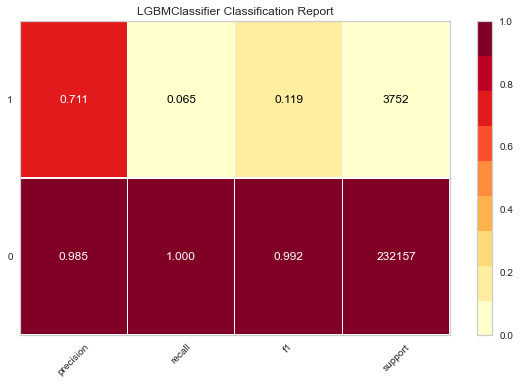

In [14]:
plot_model(lgbm, plot = 'class_report')

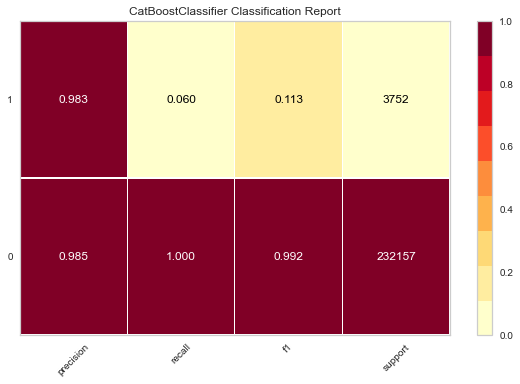

In [25]:
plot_model(catboost, plot = 'class_report')

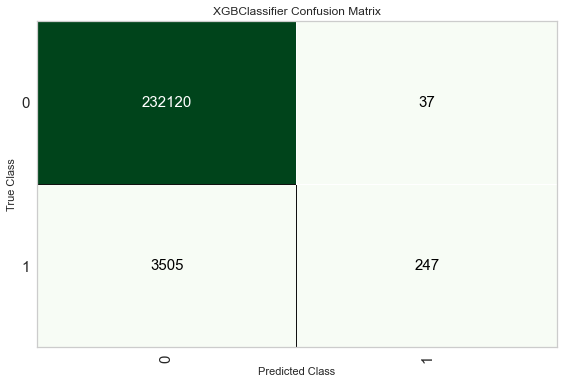

In [15]:
plot_model(xgboost, plot = 'confusion_matrix')

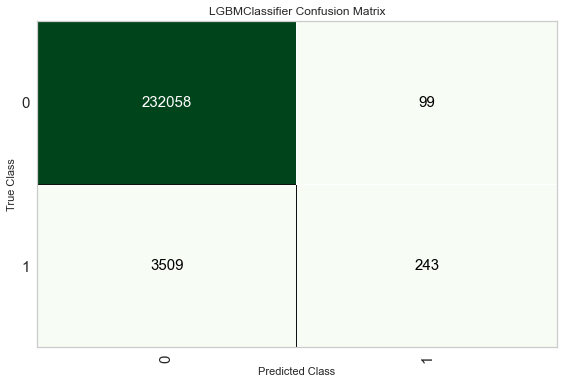

In [16]:
plot_model(lgbm, plot = 'confusion_matrix')

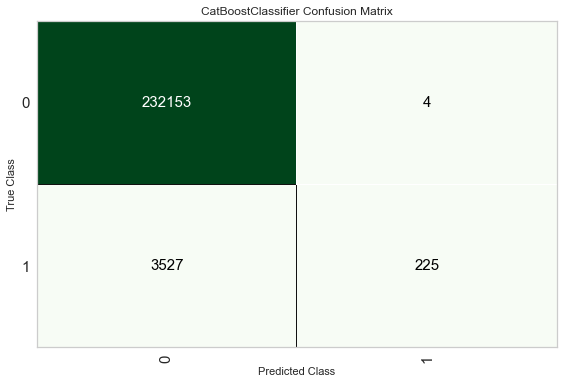

In [26]:
plot_model(catboost, plot = 'confusion_matrix')

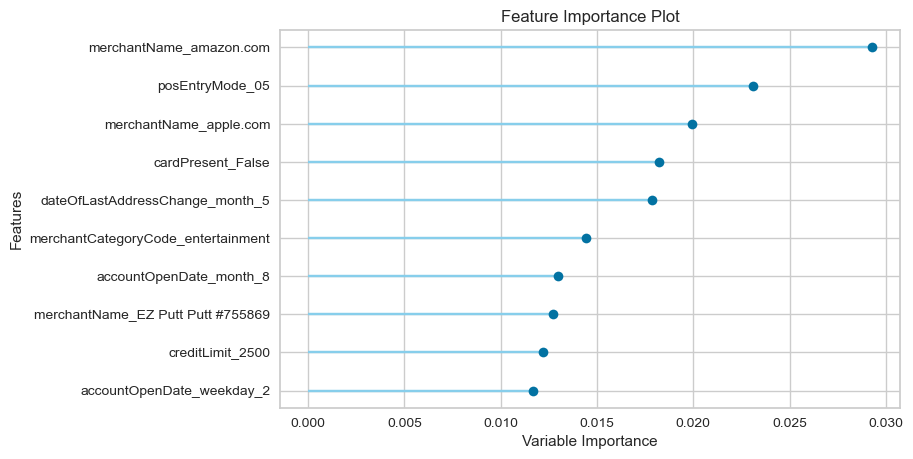

In [17]:
plot_model(xgboost, plot = 'feature')

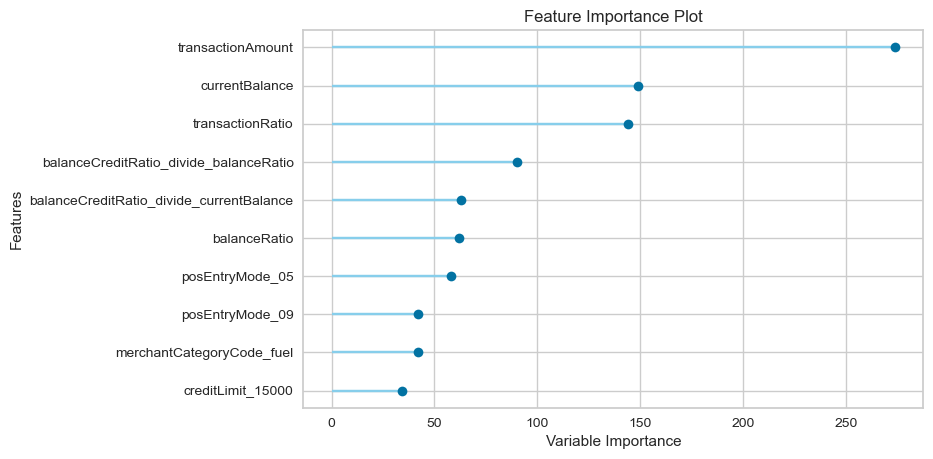

In [18]:
plot_model(lgbm, plot = 'feature')

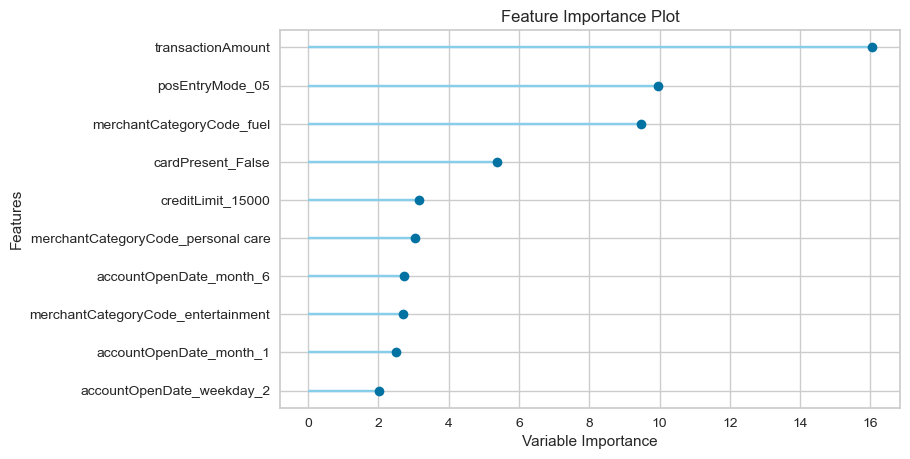

In [27]:
plot_model(catboost, plot = 'feature')

# Insights From Models

Whats interesting is that these models top 10 features are mostly different yet arrive at a similar evaluation score.

* posEntryMode_05 is the only feature in the top 10 between all 3 models.


* XGboost features indicate there are times of the day and certain merchants to look into more closely.  We have Amazon, Apple, but also EZ-Putt which seems peculiar, would warrant further investigation. 
    The feature merchantCategoryCode_entertainment also shows up in 2 models again warranting further scrutiny.  


* lgbm is also interesting in that it was the only model that utilized our manual engineered numeric ratios. We also ran feature_ratios=True in our pyCaret setup environment so we see our manual ratios put against other ratios. 

  The 4 standout features are transactionRatio, balanceCreditRatio/balanceRatio,  balanceCreditRatio/currentBalance and balanceRatio.  All these suggest a strong relationship between with currentBalance feature.  Perhaps fraudsters are monitoring when money is available in various accounts.  The feature merchantCategoryCode_fuel also appears to be one to lookout for as gas cards are a well known vehicle for fraud.  



* Catboost and lgbm had transactionAmount as the top feature and it makes sense.  During our initial EDA, we saw the average amount per fraud transaction is almost 33% above "normal" so you definitely want to watch out for the amounts.  Catboost also has merchantCategoryCode_fuel as its 3rd most important feature, again signaling us to be more alert around these types of transactions. 
  
  Both XGboost and Catboost cardPresent_False as their 4th most important feature.  Our previous EDA highlighted the discrepency in this feature between fraud/no-fraud.  This is a common sense that a stolen or fraudulent card would be absent or hidden if possible during a fraud transaction and that idea bears out in this dataset.  
  Catboost also utilizes some time of day features that would be good to analyze/explore further.  


* Overall the gradient boosting models have shown to be superior when it comes to binary classification of rare/infrequent events often with highly skewed distributions.  We can eek out a little bit of performance blending these models together.  The most effective way to improve our prediction power is by analyzing the features utilized by the models to help inform our next direction of analysis or inquiry.  This in turn will help us create better features and further refine the model.  
    It's true what they say, model optimization is more often than not a form of feature engineering.  We have a model that is strong to start and ready to be deployed, while we also have a few new lines of inquiry explore further.  



